## Problem statement
Taking into consideration all the independent features we have to predict the strength of cement.

In [1]:
# ! pip install xgboost

In [2]:
#Data manipulation libraries
import pandas as pd
import numpy as np

#Data visualisation libraries
import matplotlib.pyplot as plt
import seaborn as sns

#for bell curve
import scipy.stats as sci

#Ignoring warnings
import warnings
warnings.filterwarnings('ignore')

#Importing VIF for checking multicollinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor

#Transforming data into normal form (0 and 1)
from sklearn.preprocessing import StandardScaler

#Using pca 
from sklearn.decomposition import PCA

#Importing train test split
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, learning_curve

#Importing rfe
from sklearn.feature_selection import RFE


#Importing regressor models
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
import xgboost

#importing metrics for evaluation
from sklearn.metrics import r2_score, mean_squared_error

In [3]:
#reading data
df = pd.read_excel("Capstone Project.xlsx")
df.head()

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
0,141.3,212.0,0.0,203.5,0.0,971.8,748.5,28,29.89
1,168.9,42.2,124.3,158.3,10.8,1080.8,796.2,14,23.51
2,250.0,0.0,95.7,187.4,5.5,956.9,861.2,28,29.22
3,266.0,114.0,0.0,228.0,0.0,932.0,670.0,28,45.85
4,154.8,183.4,0.0,193.3,9.1,1047.4,696.7,28,18.29


In [4]:
df.tail()

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
1025,135.0,0.0,166.0,180.0,10.0,961.0,805.0,28,13.29
1026,531.3,0.0,0.0,141.8,28.2,852.1,893.7,3,41.30
1027,276.4,116.0,90.3,179.6,8.9,870.1,768.3,28,44.28
1028,342.0,38.0,0.0,228.0,0.0,932.0,670.0,270,55.06
1029,540.0,0.0,0.0,173.0,0.0,1125.0,613.0,7,52.61


In [5]:
df.shape

(1030, 9)

In [6]:
df.describe()

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
count,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000
mean,281.167864,73.895825,54.188350,181.567282,6.204660,972.918932,773.580485,45.662136,35.817961
std,104.506364,86.279342,63.997004,21.354219,5.973841,77.753954,80.175980,63.169912,16.705742
min,102.000000,0.000000,0.000000,121.800000,0.000000,801.000000,594.000000,1.000000,2.330000
25%,192.375000,0.000000,0.000000,164.900000,0.000000,932.000000,730.950000,7.000000,23.710000
50%,272.900000,22.000000,0.000000,185.000000,6.400000,968.000000,779.500000,28.000000,34.445000
75%,350.000000,142.950000,118.300000,192.000000,10.200000,1029.400000,824.000000,56.000000,46.135000
max,540.000000,359.400000,200.100000,247.000000,32.200000,1145.000000,992.600000,365.000000,82.600000


#### Analysis:
- As each column has count of 1030, this dataset doesn't have missing values.
- The difference bw mean and median is high which is a sign that slag, ash, age might have outliers.
- As the values for age range from 1 to 365 we can say that it is yearly data.
- Age column is only highly skewed rest all are aprroximately normal distributed.



## Building a custom summary function for EDA.

In [7]:
def describe(my_df):
    cols = []
    for i in my_df.columns:
        if my_df[i].dtype != object:
            cols.append(i)
    result = pd.DataFrame(columns= cols, index= ['Datatype', 'Count', 'min', 'Q1', 'Q2', 'mean', 'Q3', 'max', 'Std',
                                                 'Skewness', 'Kurtosis', 'Range', 'IQR', 'Skewness comment', 'Outlier comment',
                                                'Kurtosis comment'])
    for i in result.columns:
        result.loc['Datatype',i] = my_df[i].dtype
        result.loc['Count',i] = my_df[i].count()
        result.loc['min',i] = my_df[i].min()
        result.loc['Q1',i] = my_df[i].quantile(0.25)
        result.loc['Q2',i] =my_df[i].quantile(0.5)
        result.loc['mean',i] =round(my_df[i].mean(),2)
        result.loc['Q3',i] =my_df[i].quantile(0.75)
        result.loc['max',i] =my_df[i].max()
        result.loc['Std',i] =round(my_df[i].std(),2)
        result.loc['Skewness',i] =round(my_df[i].skew(),2)
        result.loc['Kurtosis',i] =round(my_df[i].kurt(),2)
        result.loc['Range',i] = my_df[i].max() - my_df[i].min()
        result.loc['IQR',i] = my_df[i].quantile(0.75) - my_df[i].quantile(0.25)
        
        
        #Adding comments for skewness
        if result.loc['Skewness', i] <= -1:
            sk_label = 'Highly negatively skewed'
        elif -1  < result.loc['Skewness', i] <= -0.5:
            sk_label = 'Moderatively negatively Skewed'
        elif -0.5  < result.loc['Skewness', i] < 0:
            sk_label = 'Approximately Normal distribution(-ve)'
        elif 0  <= result.loc['Skewness', i] < 0.5:
            sk_label = 'Approximately Normal distribution(+ve)'
        elif 0.5  <= result.loc['Skewness', i] < 1:
            sk_label = 'Moderatively positively Skewed'
        elif result.loc['Skewness', i] >= 1:
            sk_label = 'Highly positively Skewed'
        else:
            sk_label = 'Error'
            
        result.loc['Skewness comment', i] = sk_label
            
            
            
         #Adding comments for Kurtosis
        if result.loc['Kurtosis', i] <= -1:
            kt_label = 'Highly platykurtic curve'
        elif -1  < result.loc['Kurtosis', i] <= -0.5:
            kt_label = 'Moderatively platykurtic curve'
        elif -0.5  < result.loc['Kurtosis', i] < 0.5:
            kt_label = 'Mesokurtic curve'
        elif 0.5  <= result.loc['Kurtosis', i] < 1:
            kt_label = 'Moderatively laptokurtic curve'
        elif result.loc['Kurtosis', i] >= 1:
            kt_label = 'Highly laptokurtic curve'
        else:
            kt_label = 'Error'
            
        result.loc['Kurtosis comment', i] = kt_label
        
        
        #Adding comments for Outliers
        upper_limit = result.loc['Q3', i]+ (1.5 * result.loc['IQR', i])
        lower_limit = result.loc['Q1', i]- (1.5 * result.loc['IQR', i])
        if len([x for x in  my_df[i] if x < lower_limit or x > upper_limit]) > 0:
            outlier_label = 'Have outliers'
        else:
            outlier_label = 'No outliers'
        result.loc['Outlier comment', i] = outlier_label
    display(result)

In [8]:
describe(df)

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
Datatype,float64,float64,float64,float64,float64,float64,float64,int64,float64
Count,1030,1030,1030,1030,1030,1030,1030,1030,1030
min,102.0,0.0,0.0,121.8,0.0,801.0,594.0,1,2.33
Q1,192.375,0.0,0.0,164.9,0.0,932.0,730.95,7.0,23.71
Q2,272.9,22.0,0.0,185.0,6.4,968.0,779.5,28.0,34.445
mean,281.17,73.9,54.19,181.57,6.2,972.92,773.58,45.66,35.82
Q3,350.0,142.95,118.3,192.0,10.2,1029.4,824.0,56.0,46.135
max,540.0,359.4,200.1,247.0,32.2,1145.0,992.6,365,82.6
Std,104.51,86.28,64.0,21.35,5.97,77.75,80.18,63.17,16.71
Skewness,0.51,0.8,0.54,0.07,0.91,-0.04,-0.25,3.27,0.42


## Analysis from custom summary
1. All features are numerical.
2. none of the columns have missing value.
3. Age is only feature which is highly skewed.
4. six columns have outliers.
5. Three columns have kurtosis.
6. slag, ash and superplastic do not having outliers towards the lower whisker as minimum & Q1 are same.
7. Age column has values in days since the value ranges from 1 to 365.

## Performing outlier treatment

In [9]:
def replace_outlier(df, col, method = 'Quartile', strategy = 'median'):
    col_data = df[col]
    
    
    #using quartile to set the values
    if method == 'Quartile':
        Q2 = col_data.quantile(0.5)
        Q1 = col_data.quantile(0.25)
        Q3 = col_data.quantile(0.75)
        
        IQR = Q3 - Q1
        lower_limit = Q1 - 1.5 * IQR
        upper_limit = Q3 + 1.5 * IQR
        
    #using stdev to set the values
    elif method == 'stdev':
        mean = col_data.mean()
        stdev = col_data.std()
    
        lower_limit = mean - 2* stdev
        upper_limit = mean + 2* stdev
    
    else:
        print('pass a correct method')
        
    #Checking outliers and density
    outliers = df.loc[(col_data < lower_limit) | (col_data > upper_limit), col]
    outlier_density = round(len(outliers)/ len(df), 2)

    if len(outliers) == 0:
        print(f'Feature {col} does not have any outliers')
        print('\n')
        
    else: 
        print(f'Feature {col} has outliers')
        print('\n')
        print(f'Total no of outliers in {col} are {len(outliers)}')
        print('\n')
        print(f'Outlier percentage in {col} is {outlier_density}')
        print('\n')
        
        display(df[(col_data < lower_limit) | (col_data > upper_limit)]) #It will display outliers 


    #Replacing outliers
    if strategy == 'median':
        df.loc[(col_data < lower_limit) | (col_data > upper_limit), col] = Q2
    elif strategy == 'mean':
        df.loc[(col_data < lower_limit) | (col_data > upper_limit), col] = mean
    else:
        print('pass a correct strategy')
        
    return(df)
        
        
        

## ODT plots 
1. Descriptive plot.
2. Histogram with outliers.
3. Histogram without outliers.

In [10]:
def odt_plots(df, col):
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize= (25, 8))
    # descriptive statistics boxplots 
    sns.boxplot(df[col], ax= ax1)
    ax1.set_title(col + ' boxplot')
    ax1.set_xlabel('Boxplot')
    ax1.set_ylabel('values')
    
    #plotting histogram with outliers
    sns.distplot(df[col], ax= ax2, fit = sci.norm) #sci.norm will give bell curve 
    ax2.axvline(df[col].mean(), color= 'g')
    ax2.axvline(df[col].median(), color= 'b')
    ax2.set_title(col + ' Histogram with outliers')
    ax2.set_xlabel('Boxplot')
    ax2.set_ylabel('values')
    
    #Replacing outliers
    df_out = replace_outlier(df, col)
    
     #plotting histogram without outliers
    sns.distplot(df[col], ax= ax3, fit= sci.norm)
    ax3.axvline(df[col].mean(), color= 'g')
    ax3.axvline(df[col].median(), color= 'b')
    ax3.set_title(col + ' Histogram without outliers')
    ax3.set_xlabel('Density')
    ax3.set_ylabel('values')
    plt.show()
    
    

Feature cement does not have any outliers




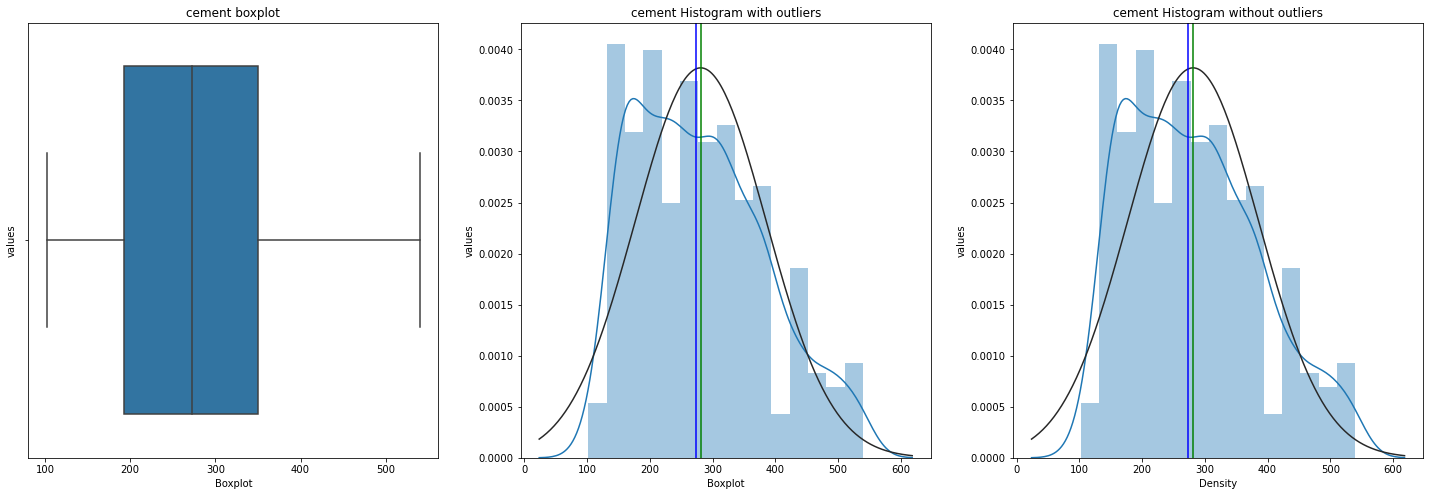

Feature slag has outliers


Total no of outliers in slag are 2


Outlier percentage in slag is 0.0




,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
918,239.6,359.4,0.0,185.7,0.0,941.6,664.3,28,39.44
990,239.6,359.4,0.0,185.7,0.0,941.6,664.3,7,25.42


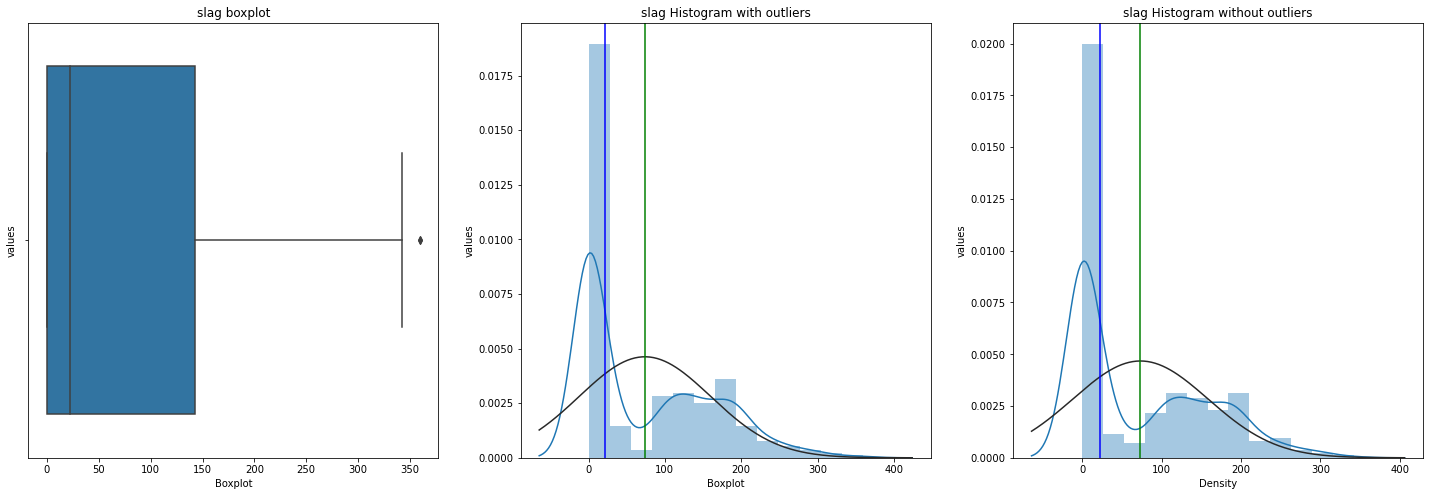

Feature ash does not have any outliers




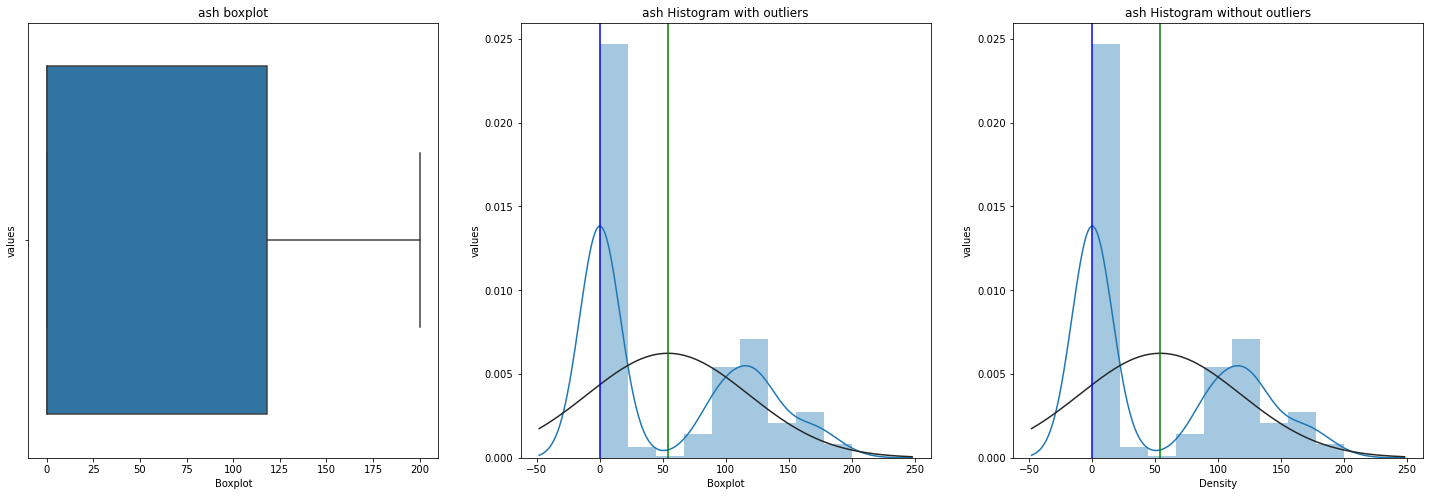

Feature water has outliers


Total no of outliers in water are 9


Outlier percentage in water is 0.01




,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
66,237.0,92.0,71.0,247.0,6.0,853.0,695.0,28,28.63
263,236.9,91.7,71.5,246.9,6.0,852.9,695.4,28,28.63
432,168.0,42.1,163.8,121.8,5.7,1058.7,780.1,28,24.24
462,168.0,42.1,163.8,121.8,5.7,1058.7,780.1,100,39.23
587,168.0,42.1,163.8,121.8,5.7,1058.7,780.1,3,7.75
740,140.0,164.0,128.0,237.0,6.0,869.0,656.0,28,35.23
789,168.0,42.1,163.8,121.8,5.7,1058.7,780.1,56,32.85
826,139.7,163.9,127.7,236.7,5.8,868.6,655.6,28,35.23
914,168.0,42.1,163.8,121.8,5.7,1058.7,780.1,14,17.82


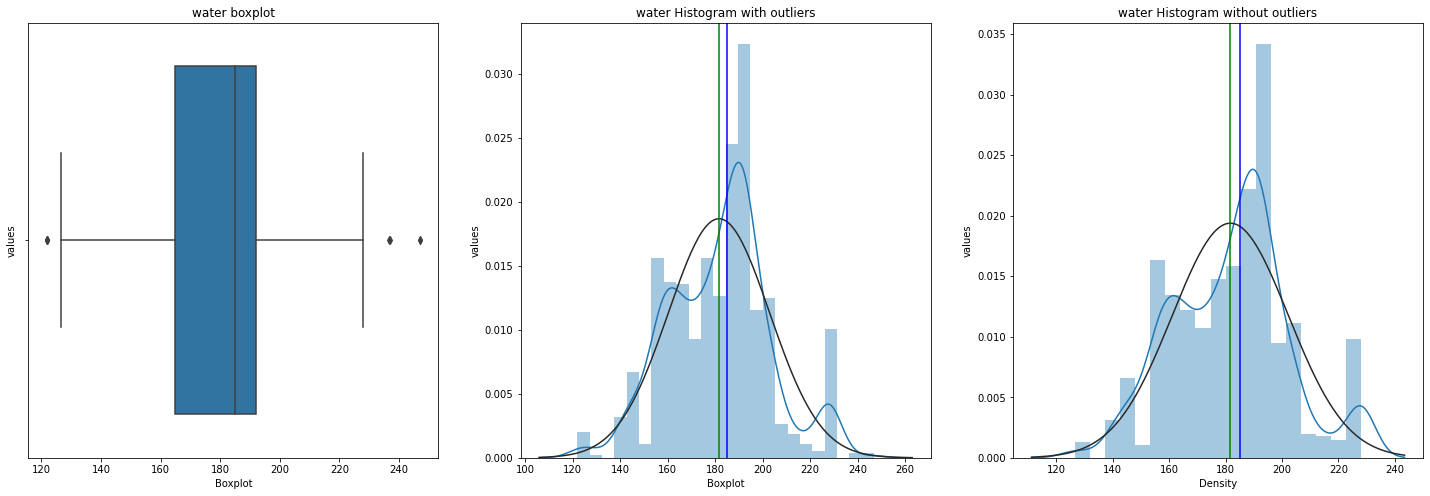

Feature superplastic has outliers


Total no of outliers in superplastic are 10


Outlier percentage in superplastic is 0.01




,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
44,531.3,0.0,0.0,141.8,28.2,852.1,893.7,91,59.2
156,531.3,0.0,0.0,141.8,28.2,852.1,893.7,28,56.4
232,469.0,117.2,0.0,137.8,32.2,852.1,840.5,56,69.3
292,469.0,117.2,0.0,137.8,32.2,852.1,840.5,91,70.7
538,531.3,0.0,0.0,141.8,28.2,852.1,893.7,7,46.9
744,469.0,117.2,0.0,137.8,32.2,852.1,840.5,7,54.9
816,469.0,117.2,0.0,137.8,32.2,852.1,840.5,28,66.9
838,531.3,0.0,0.0,141.8,28.2,852.1,893.7,56,58.8
955,469.0,117.2,0.0,137.8,32.2,852.1,840.5,3,40.2
1026,531.3,0.0,0.0,141.8,28.2,852.1,893.7,3,41.3


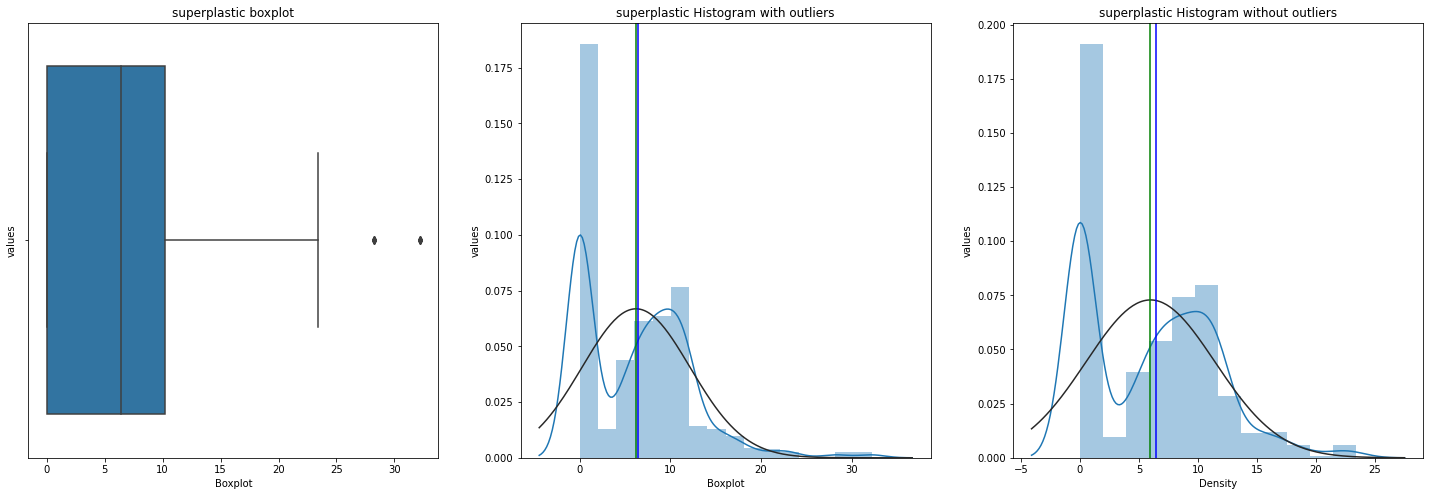

Feature coarseagg does not have any outliers




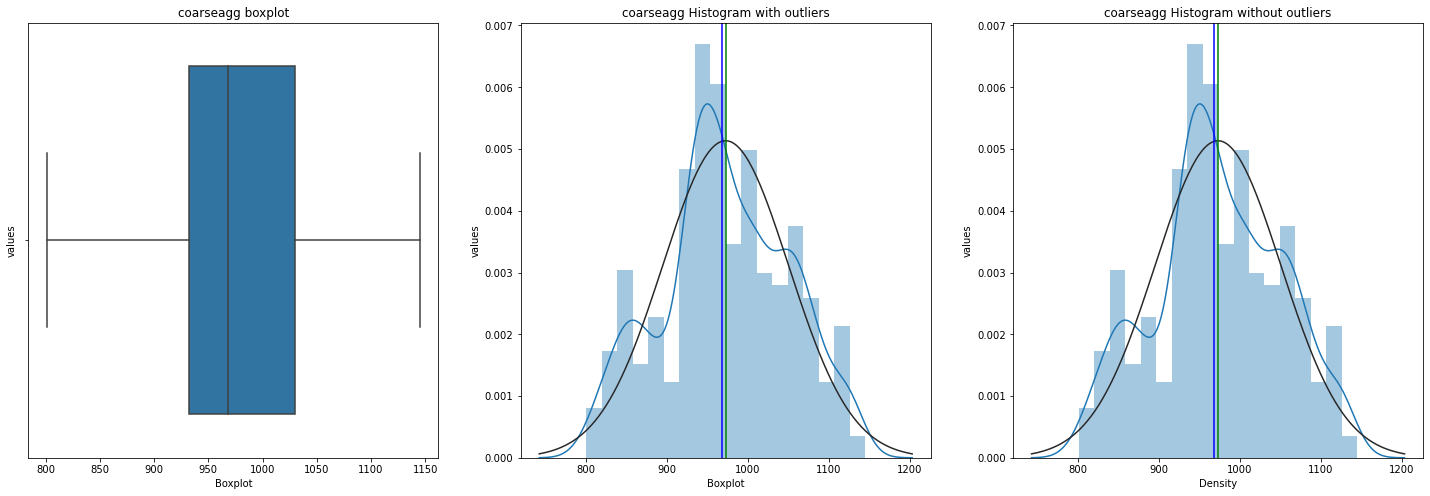

Feature fineagg has outliers


Total no of outliers in fineagg are 5


Outlier percentage in fineagg is 0.0




,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
129,375.0,93.8,0.0,126.6,23.4,852.1,992.6,91,62.5
447,375.0,93.8,0.0,126.6,23.4,852.1,992.6,7,45.7
504,375.0,93.8,0.0,126.6,23.4,852.1,992.6,3,29.0
584,375.0,93.8,0.0,126.6,23.4,852.1,992.6,56,60.2
857,375.0,93.8,0.0,126.6,23.4,852.1,992.6,28,56.7


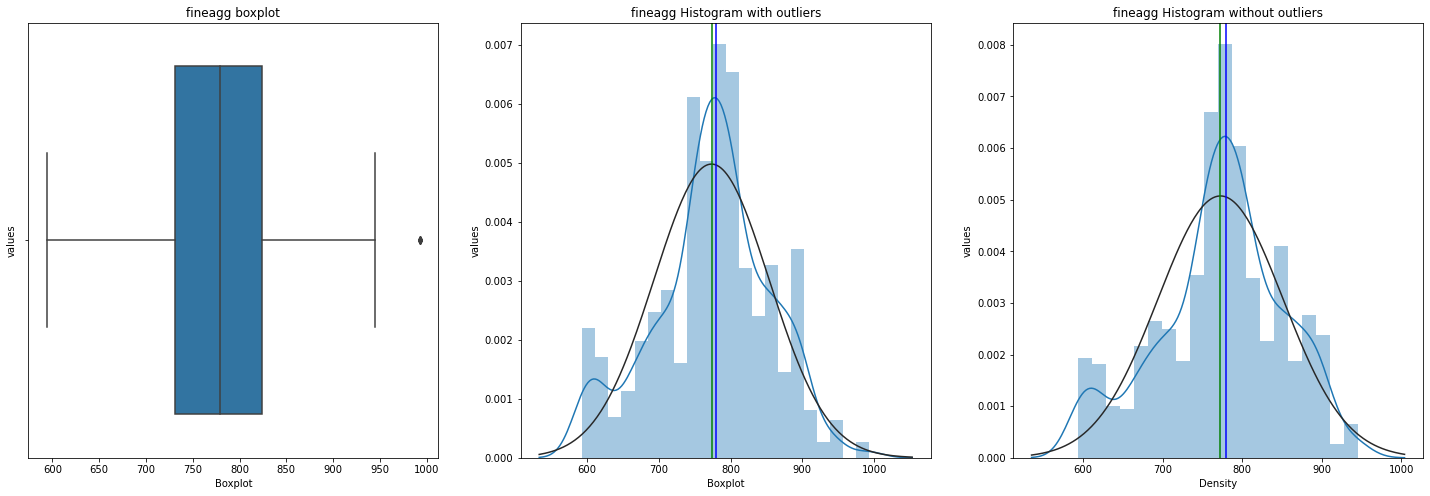

Feature age has outliers


Total no of outliers in age are 59


Outlier percentage in age is 0.06




,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
51,331.0,0.0,0.0,192.0,0.0,978.0,825.0,180,39.00
64,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
93,427.5,47.5,0.0,228.0,0.0,932.0,594.0,180,41.84
99,237.5,237.5,0.0,228.0,0.0,932.0,594.0,180,36.25
103,380.0,0.0,0.0,228.0,0.0,932.0,670.0,180,53.10
133,236.0,0.0,0.0,193.0,0.0,968.0,885.0,365,25.08
144,302.0,0.0,0.0,203.0,0.0,974.0,817.0,180,26.74
149,380.0,95.0,0.0,228.0,0.0,932.0,594.0,270,41.15
152,322.0,0.0,0.0,203.0,0.0,974.0,800.0,180,29.59
157,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


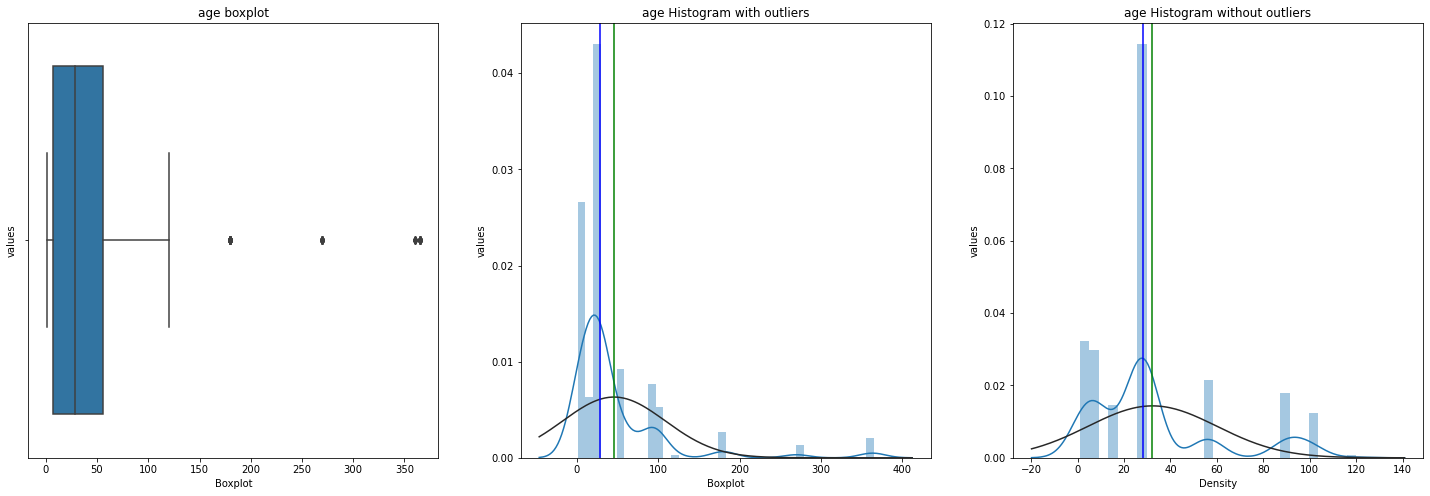

Feature strength has outliers


Total no of outliers in strength are 4


Outlier percentage in strength is 0.0




,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
192,315.0,137.0,0.0,145.0,5.9,1130.0,745.0,28.0,81.75
732,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28.0,79.99
950,389.9,189.0,0.0,145.9,22.0,944.7,755.8,91.0,82.60
1003,323.7,282.8,0.0,183.8,10.3,942.7,659.9,56.0,80.20


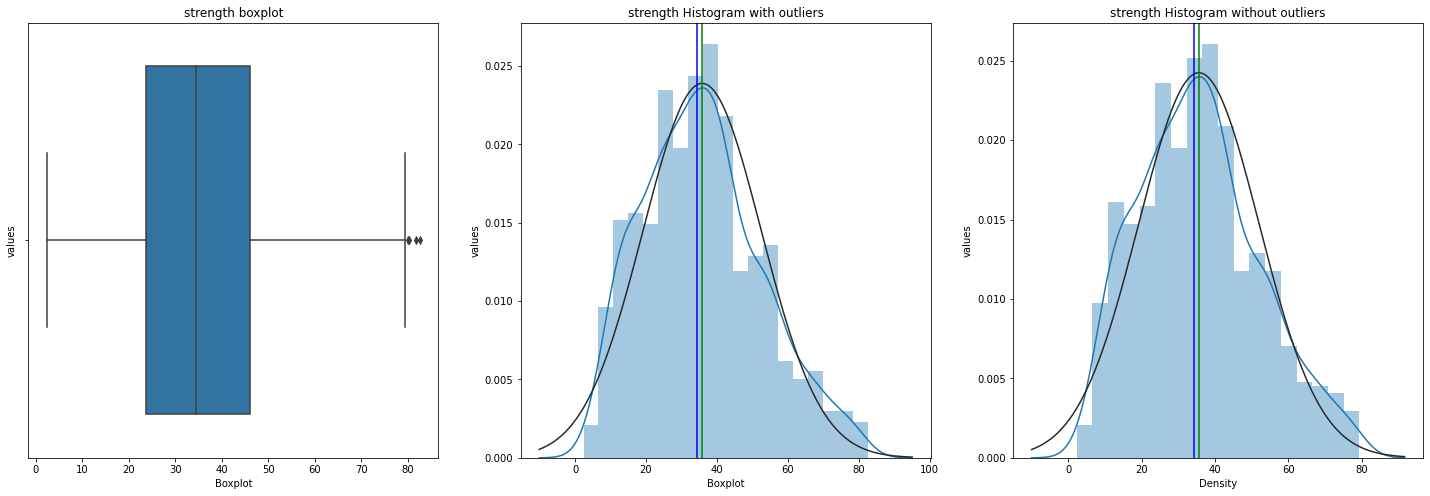

In [11]:
for col in df.columns:
    odt_plots(df, col)

## Multivariate analysis using regression

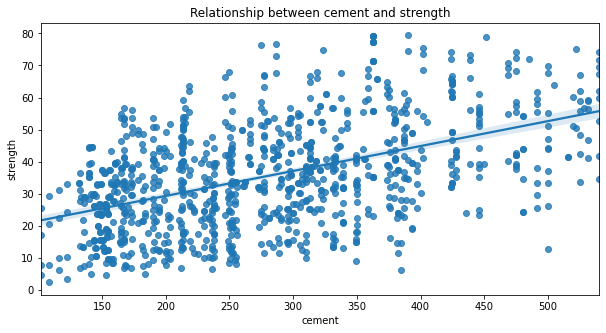

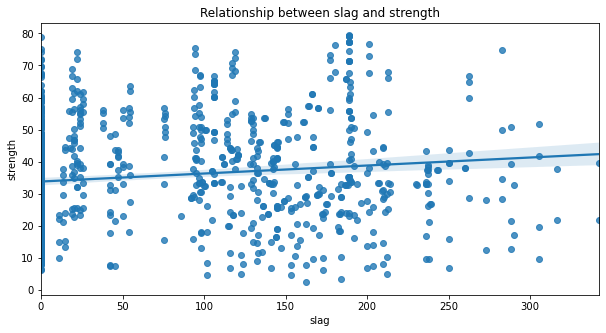

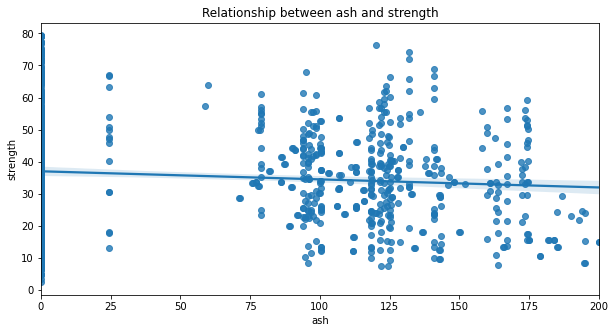

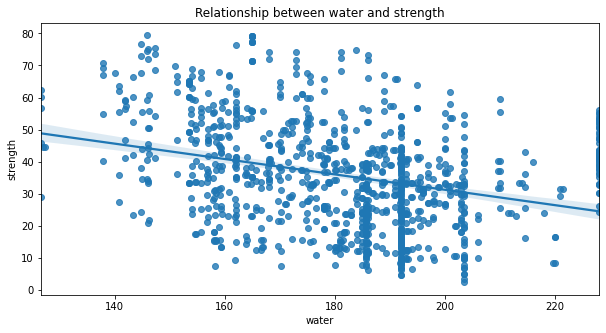

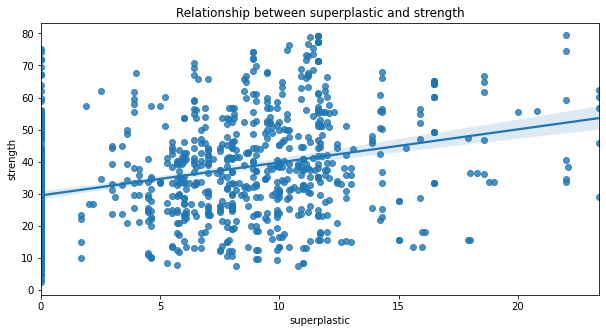

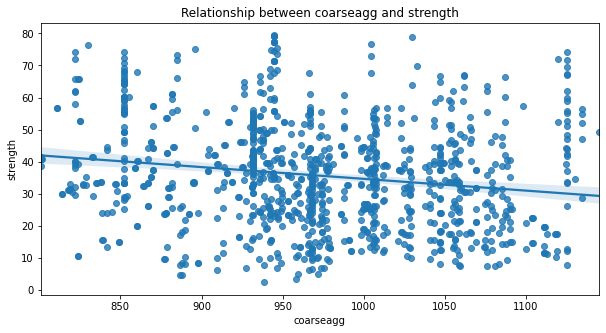

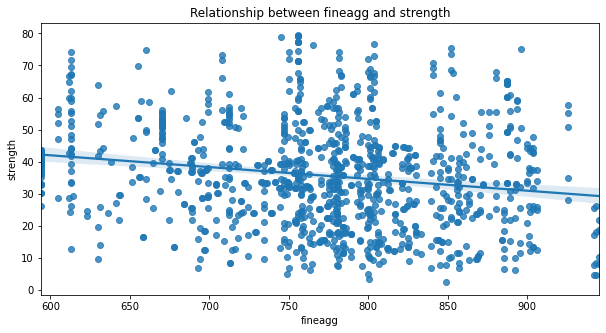

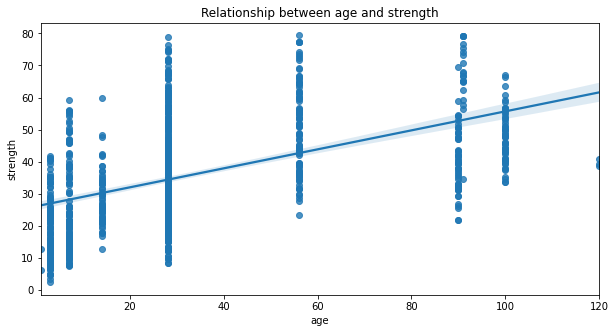

In [12]:
for col in df.columns:
    if col != 'strength': #this is to compare each column with strength except strength
        fig, ax1 = plt.subplots(figsize = (10,5))
        sns.regplot(x = df[col], y= df['strength'], ax= ax1).set_title(f'Relationship between {col} and strength')
        

## Analysis
1. cement & strength are highly positively correlated.
2. slag and strength are slightly positively correlated.
3. ash and strength are slightly negatively correlated.
4. water and strength are highly negatively correlated.
5. superplastic and strength are highly positively correlated.
6. coarseagg and strength are slightly negatively correlated.
7. fineagg and strength are slightly negatively correlated.
8. age and strength are highly positively correlated.

## Multicollinearity check
1. Stage 1: correlation matrix/ heatmap

In [13]:
corr = df.corr()

<AxesSubplot:>

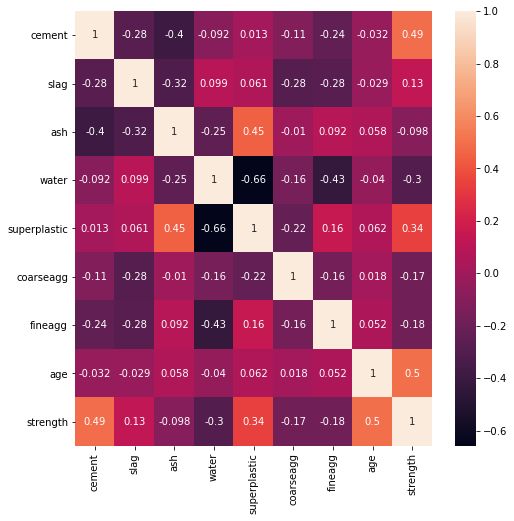

In [14]:
f, ax = plt.subplots(figsize=(8,8))
sns.heatmap(corr, annot= True)

## Analysis:
1. cement and ash has 40% correlation.
2. age and strength has 50% correlation.
3. ash and superplastic has 45% correlation.
4. strength and cement has 49 % correlation.

## Multicollinearity check 2
- stage 2: VIF(Variance Inflation factor)
- Formula for VIF is: 1 / (1 - r2)
- steps to calculTE vif:
1. Regress every independent variable with each other and find the r2.
2. Find out the VIF using the formula.
3. If VIF > 5 we say multicollinearity exist.

In [15]:
def VIF(features):
    VIF = pd.DataFrame()
    VIF['vif_factor'] = [variance_inflation_factor(features.values, i) for i in range(features.shape[1])]
    VIF['features'] = features.columns
    return VIF.sort_values('vif_factor', ascending= False)

In [16]:
VIF(df.drop('strength', axis=1))

,vif_factor,features
5,86.938582,coarseagg
3,81.963087,water
6,68.664404,fineagg
0,14.291158,cement
4,5.724145,superplastic
2,4.415840,ash
1,3.342314,slag
7,2.368372,age


In [17]:
#diff bw correlation, collinearity and multicollinearity.

## Analysis
- Many features have VIF more than 5 so we can conclude that multicollinearity exist.

## Correlation with target feature

In [18]:
def correlation_with_target(data, tcol):
    independent_variables = data.drop(tcol, axis=1).columns
    corr_result = []
    for col in independent_variables:
        corr_result.append(data[tcol].corr(data[col]))
    result = pd.DataFrame([independent_variables, corr_result], index=['independent_variables', 'correlation']).T
    return result.sort_values('correlation', ascending= False)

In [19]:
correlation_with_target(df, 'strength')

,independent_variables,correlation
7,age,0.499711
0,cement,0.493518
4,superplastic,0.342633
1,slag,0.129561
2,ash,-0.097973
5,coarseagg,-0.173234
6,fineagg,-0.176113
3,water,-0.300043


## Analysis
- Age and cement have 49 percent correlation.
- superplastic have 34 % and water has -30 % negative corr.

## Applying PCA to treat multicollinearity

In [20]:
def PCA1(x):
    n_comp = len(x.columns)   #no. of columns in df
    
    #Applying standard scaler
    x = StandardScaler().fit_transform(x) # This will transform features in such a way that it will have the properties 
                                          # of normal distribution with mean = 0 & sd = 1.
    
    
    #Applying PCA
    for i in range(1, n_comp):         
        pca = PCA(n_components = i)      # it will apply pca to 1st col then 1,2 then 1,2,3 and so on till 8
        p_comp = pca.fit_transform(x)
        evr = np.cumsum(pca.explained_variance_ratio_)  
        if evr[i-1] > 0.9:               # this will check ratio of 2nd last pca
            n_components = i
            break
    print('explained_variance_ratio after PCA is :', evr)
    
    #Creating a dataframe
    col = []
    for j in range(1, n_components + 1):
        col.append('pc_'+ str(j))
    pca_df = pd.DataFrame(p_comp, columns=col)
    return pca_df

In [21]:
transform_df = PCA1(df.drop('strength', axis=1))

explained_variance_ratio after PCA is : [0.27112429 0.44666571 0.60914114 0.73584634 0.85926016 0.97264602]


In [22]:
#Features after transformation
transform_df.head()

,pc_1,pc_2,pc_3,pc_4,pc_5,pc_6
0,1.810919,1.331664,-1.284484,-0.306148,-0.067652,-0.886110
1,-1.823833,-0.573436,-1.058973,0.893130,-0.913984,-0.751061
2,-0.739819,-0.463200,-0.541643,-1.033210,-0.308068,0.611045
3,2.766368,0.602978,-0.512532,0.008806,0.086415,0.850548
4,0.892523,0.966627,-0.863624,1.148561,-0.064439,-1.221228


## Joining pca features with target feature

In [23]:
transform_df = transform_df.join(df['strength'], how= 'left')

In [24]:
transform_df.head()

,pc_1,pc_2,pc_3,pc_4,pc_5,pc_6,strength
0,1.810919,1.331664,-1.284484,-0.306148,-0.067652,-0.886110,29.89
1,-1.823833,-0.573436,-1.058973,0.893130,-0.913984,-0.751061,23.51
2,-0.739819,-0.463200,-0.541643,-1.033210,-0.308068,0.611045,29.22
3,2.766368,0.602978,-0.512532,0.008806,0.086415,0.850548,45.85
4,0.892523,0.966627,-0.863624,1.148561,-0.064439,-1.221228,18.29


## Model Building
1. Train-test split
2. Cross-validation
3. Hyperparameter tuning

#### Train test split Function

In [25]:
def train_and_test_split(data, tcol, Test_size=0.3, Random_state = 42):
    x = data.drop(tcol, axis= 1)
    y = data[tcol]
    return train_test_split(x, y, test_size= Test_size, random_state=Random_state)

#### Model building function

In [26]:
def build_model(model_name, estimator, data, tcol):
    xtrain, xtest, ytrain, ytest = train_and_test_split(data, tcol)
    estimator.fit(xtrain, ytrain)
    ypred = estimator.predict(xtest)
    rmse = np.sqrt(mean_squared_error(ytest, ypred))
    accuracy = r2_score(ytest, ypred)
    return [model_name, rmse, accuracy]

In [27]:
build_model(model_name= 'Linear Regression', estimator= LinearRegression(), data= transform_df, tcol= 'strength')

['Linear Regression', 9.574377990891843, 0.6268240358306476]

## Building multiple models function

In [28]:
def multiple_models(data, tcol):
    colnames = ['model_name', 'rmse', 'r2_score']
    result = pd.DataFrame(columns= colnames)
    result.loc[len(result)] = build_model('Linear regression', LinearRegression(), data, tcol)
    result.loc[len(result)] = build_model('Lasso regression', Lasso(), data, tcol)
    result.loc[len(result)] = build_model('Ridge regression', Ridge(), data, tcol)
    result.loc[len(result)] = build_model('SVR', SVR(), data, tcol)
    result.loc[len(result)] = build_model('KNeighborsRegressor', KNeighborsRegressor(), data, tcol)
    result.loc[len(result)] = build_model('RandomForestRegressor', RandomForestRegressor(), data, tcol)
    result.loc[len(result)] = build_model('XGBRegressor', XGBRegressor(), data, tcol)
    result.loc[len(result)] = build_model('DecisionTreeRegressor', DecisionTreeRegressor(), data, tcol)
    result.loc[len(result)] = build_model('AdaBoostRegressor', AdaBoostRegressor(), data, tcol)
    result.loc[len(result)] = build_model('GradientBoostingRegressor', GradientBoostingRegressor(), data, tcol)
    
    return result.sort_values('r2_score', ascending= False)

In [29]:
multiple_models(transform_df, 'strength')

,model_name,rmse,r2_score
5,RandomForestRegressor,6.148656,0.846095
6,XGBRegressor,6.259367,0.840503
9,GradientBoostingRegressor,6.793772,0.812105
7,DecisionTreeRegressor,7.440498,0.774630
8,AdaBoostRegressor,7.941928,0.743230
4,KNeighborsRegressor,8.045060,0.736518
3,SVR,8.685040,0.692931
1,Lasso regression,9.439787,0.637242
2,Ridge regression,9.571666,0.627035
0,Linear regression,9.574378,0.626824


## Cross validation

In [30]:
def K_fold_CV(x, y, fold=10):
    score_lr = cross_val_score(LinearRegression(), x, y, cv= fold)
    score_la = cross_val_score(Lasso(), x, y, cv= fold)
    score_ri = cross_val_score(Ridge(), x, y, cv= fold)
    score_svr = cross_val_score(SVR(), x, y, cv= fold)
    score_dt = cross_val_score(DecisionTreeRegressor(), x, y, cv= fold)
    score_knn = cross_val_score(KNeighborsRegressor(), x, y, cv= fold)
    score_rm = cross_val_score(RandomForestRegressor(), x, y, cv= fold)
    score_ad = cross_val_score(AdaBoostRegressor(), x, y, cv= fold)
    score_gr = cross_val_score(GradientBoostingRegressor(), x, y, cv= fold)
    score_xgb = cross_val_score(XGBRegressor(), x, y, cv= fold)
    
    model_names = ['LinearRegression', 'Lasso', 'Ridge', 'SVR', 'DecisionTreeRegressor', 'KNeighborsRegressor', 
                   'RandomForestRegressor', 'AdaBoostRegressor', 'GradientBoostingRegressor', 'XGBRegressor']
    
    scores = [score_lr, score_la, score_ri, score_svr, score_dt, score_knn, score_rm, score_ad, score_gr, score_xgb]
    result = []
    for i in range(len(model_names)):
        score_mean = np.mean(scores[i])
        score_std = np.std(scores[i])
        m_names = model_names[i]
        temp = [m_names, score_mean, score_std]
        result.append(temp)
    
    K_fold_df = pd.DataFrame(result, columns= ['model_names', 'score_mean', 'score_std'])
    return K_fold_df.sort_values('score_mean', ascending= False)

In [31]:
K_fold_CV(x = transform_df.drop('strength', axis=1), y=transform_df['strength'])

,model_names,score_mean,score_std
9,XGBRegressor,0.873262,0.036061
6,RandomForestRegressor,0.866540,0.031130
8,GradientBoostingRegressor,0.828721,0.049964
5,KNeighborsRegressor,0.767666,0.055620
4,DecisionTreeRegressor,0.763576,0.061478
7,AdaBoostRegressor,0.723712,0.038090
3,SVR,0.703117,0.042765
2,Ridge,0.663935,0.059437
0,LinearRegression,0.663928,0.059476
1,Lasso,0.649837,0.049887


### Top 5 models 
1. RandomForestRgressor
2. XGBr
3. GB
4. Kneighbour
5. AdaB

## Hyperparameter tuning

In [32]:
def tuning(x,y, fold= 10):
    #parameter grid for all the models
    param_dt = {'criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'], 'max_features': ['auto','sqrt','log2',2,3,4,5,6,7,8]}
    param_knn = {'n_neighbors': [5, 10, 20, 40, 60, 80, 100]}
    param_rf = {'n_estimators': [100, 200, 300], 'max_depth': [3,5,7,10]}
    param_ad = {'n_estimators': [100, 200, 300], 'loss': ['linear', 'square', 'exponential']} #, 'base_estimator': ['LinearRegression', 'DecisionTreeRegressor']
    param_gr = {'n_estimators': [200, 300], 'learning_rate':[0.1, 0.01]}
    param_xgb = {'eta': [0.01, 0.1, 0.3], 'max_depth':[3,5,7,10], 'subsample': [0.5, 0.7, 1]}
    param_rd = {'alpha': [1e-15, 1e-13, 1e-11, 1e-9, 1e-7, 1e-5, 1e-3, 1e-1, 0, 1,2,3,4,5,6,7,8,9,10,20,30,40,50,60,70,80,90,100,200,300,400,500]}
    param_ls = {'alpha': [1e-15, 1e-13, 1e-11, 1e-9, 1e-7, 1e-5, 1e-3, 1e-1, 0, 1,2,3,4,5,6,7,8,9,10,20,30,40,50,60,70,80,90,100,200,300,400,500]}
    #param_svr = {}
                
    
    
# hyperparameter tuning (passing hyperparameters in gridsearch)

    tuned_las = GridSearchCV(Lasso(), param_ls, cv= fold)
    tuned_rd = GridSearchCV(Ridge(), param_rd, cv= fold)
    tuned_knn = GridSearchCV(KNeighborsRegressor(), param_knn, cv= fold)
    tuned_dt = GridSearchCV(DecisionTreeRegressor(), param_dt, cv= fold)
    tuned_rf = GridSearchCV(RandomForestRegressor(), param_rf, cv= fold)
    tuned_ad = GridSearchCV(AdaBoostRegressor(), param_ad, cv= fold)
    tuned_gr = GridSearchCV(GradientBoostingRegressor(), param_gr, cv= fold)
    tuned_xgb = GridSearchCV(XGBRegressor(), param_xgb, cv= fold)
    
    
#Fitting x and y
    tuned_las.fit(x, y)
    tuned_rd.fit(x, y)
    tuned_knn.fit(x, y)
    tuned_dt.fit(x, y)
    tuned_rf.fit(x, y)
    tuned_ad.fit(x, y)
    tuned_gr.fit(x, y)
    tuned_xgb.fit(x, y)
    
    tune = [tuned_las, tuned_rd, tuned_knn, tuned_dt, tuned_rf, tuned_ad, tuned_gr, tuned_xgb]
    models = ['Lasso', 'Ridge', 'Knn', 'Decision_Tree', 'Random_forest', 'Adaboost', 'Gboost', 'XGBoost']
    for i in range(len(tune)):
        print('models: ', models[i])
        print('best_params: ',tune[i].best_params_)

In [33]:
tuning(transform_df.drop('strength', axis=1), y= transform_df['strength'])

models:  Lasso
best_params:  {'alpha': 0.1}
models:  Ridge
best_params:  {'alpha': 6}
models:  Knn
best_params:  {'n_neighbors': 5}
models:  Decision_Tree
best_params:  {'criterion': 'friedman_mse', 'max_features': 4}
models:  Random_forest
best_params:  {'max_depth': 10, 'n_estimators': 300}
models:  Adaboost
best_params:  {'loss': 'square', 'n_estimators': 200}
models:  Gboost
best_params:  {'learning_rate': 0.1, 'n_estimators': 300}
models:  XGBoost
best_params:  {'eta': 0.1, 'max_depth': 7, 'subsample': 0.5}


## Post hyperparameter tuning

In [34]:
def cv_post_hpt(x, y, fold=10):
    score_lr = cross_val_score(LinearRegression(), x, y, cv= fold)
    score_la = cross_val_score(Lasso(alpha =0.1), x, y, cv= fold)
    score_ri = cross_val_score(Ridge(alpha =0.6), x, y, cv= fold)
    score_svr = cross_val_score(SVR(), x, y, cv= fold)
    score_dt = cross_val_score(DecisionTreeRegressor(criterion='friedman_mse' , max_features= 5), x, y, cv= fold)
    score_knn = cross_val_score(KNeighborsRegressor(n_neighbors= 5), x, y, cv= fold)
    score_rm = cross_val_score(RandomForestRegressor(n_estimators =300 , max_depth=10 ), x, y, cv= fold)
    score_ad = cross_val_score(AdaBoostRegressor(n_estimators=100 , loss='square'), x, y, cv= fold)
    score_gr = cross_val_score(GradientBoostingRegressor(n_estimators=300 , learning_rate=0.1 ), x, y, cv= fold)
    score_xgb = cross_val_score(XGBRegressor(eta=0.1 , max_depth=7 , subsample=0.5 ), x, y, cv= fold)
    
    model_names = ['LinearRegression', 'Lasso', 'Ridge', 'SVR', 'DecisionTreeRegressor', 'KNeighborsRegressor', 
                   'RandomForestRegressor', 'AdaBoostRegressor', 'GradientBoostingRegressor', 'XGBRegressor']
    
    scores = [score_lr, score_la, score_ri, score_svr, score_dt, score_knn, score_rm, score_ad, score_gr, score_xgb]
    result = []
    for i in range(len(model_names)):
        score_mean = np.mean(scores[i])
        score_std = np.std(scores[i])
        m_names = model_names[i]
        temp = [m_names, score_mean, score_std]
        result.append(temp)
    
    K_fold_df = pd.DataFrame(result, columns= ['model_names', 'score_mean', 'score_std'])
    return K_fold_df.sort_values('score_mean', ascending= False)

In [35]:
cv_post_hpt(transform_df.drop('strength', axis=1), y= transform_df['strength'])

,model_names,score_mean,score_std
9,XGBRegressor,0.882546,0.038120
8,GradientBoostingRegressor,0.860181,0.047999
6,RandomForestRegressor,0.859934,0.033178
4,DecisionTreeRegressor,0.769553,0.070391
5,KNeighborsRegressor,0.767666,0.055620
7,AdaBoostRegressor,0.723930,0.040729
3,SVR,0.703117,0.042765
1,Lasso,0.664143,0.058426
2,Ridge,0.663932,0.059452
0,LinearRegression,0.663928,0.059476


## Clustering

In [36]:
from sklearn.cluster import KMeans

In [37]:
labels = KMeans(n_clusters=2, random_state=50)

In [38]:
clusters = labels.fit_predict(df.drop('strength', axis=1))

<AxesSubplot:xlabel='cement', ylabel='strength'>

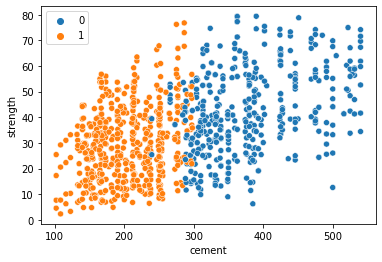

In [39]:
sns.scatterplot(x= df['cement'], y= df['strength'], hue=clusters) #comparing one feature with target

## udf for comparing features and target using clustering scatterplot

In [40]:
def clustering(x, tcol, cluster):
    column = list(set(list(x.columns))- set(df['strength'])) #x.columns return clumns of df in list format,
    #then removing duplicate entries by set of these columns and subtracting with set of strength.
                                                                            
    r = int(len(column) / 2)  #checking length of columns and int is used bcz r cannot be in float value.
    if r %2 == 0:
        r = r
    else:
        r += 1

        
    f, ax = plt.subplots(r,2, figsize= (15,15))
    a = 0
    for row in range(r):
        for col in range(0,2):
            if a != len(column):
                ax[row][col].scatter(x[tcol], x[column[a]], c= cluster)
                ax[row][col].set_xlabel(tcol)
                ax[row][col].set_ylabel(column[a])
                a += 1

In [41]:
x = df.drop('strength', axis=1)

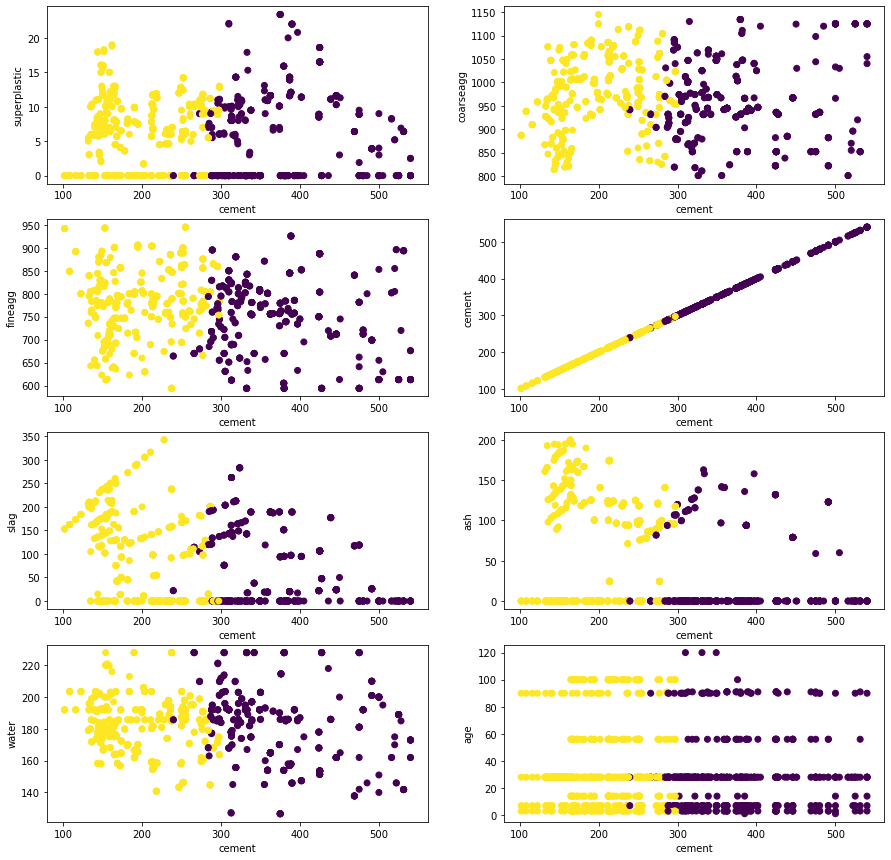

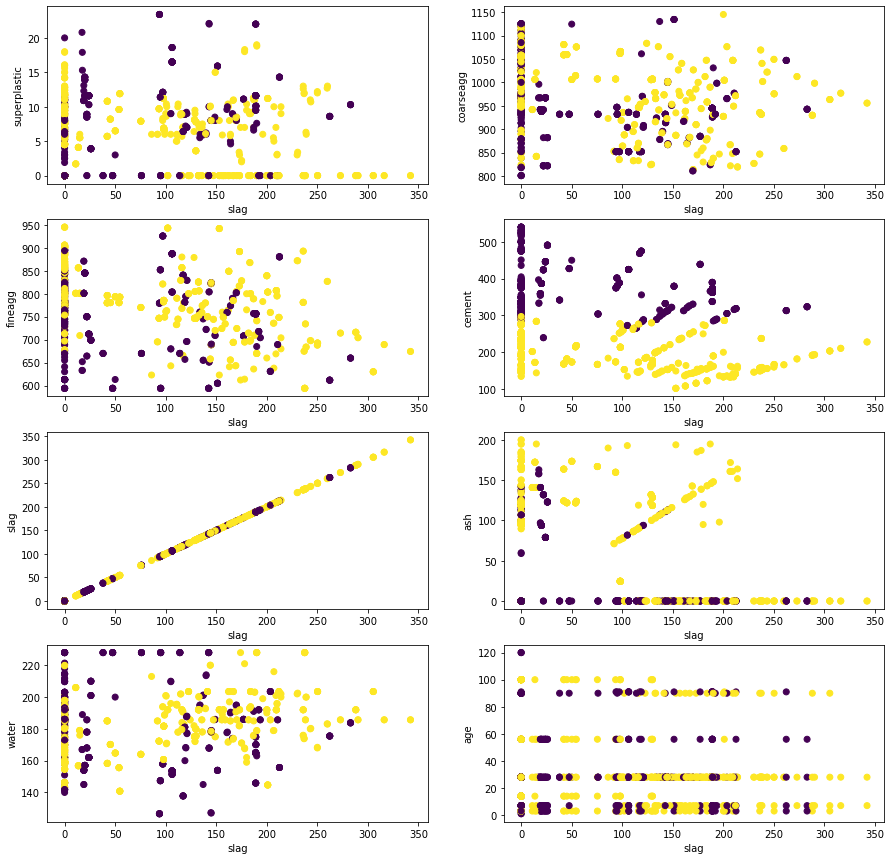

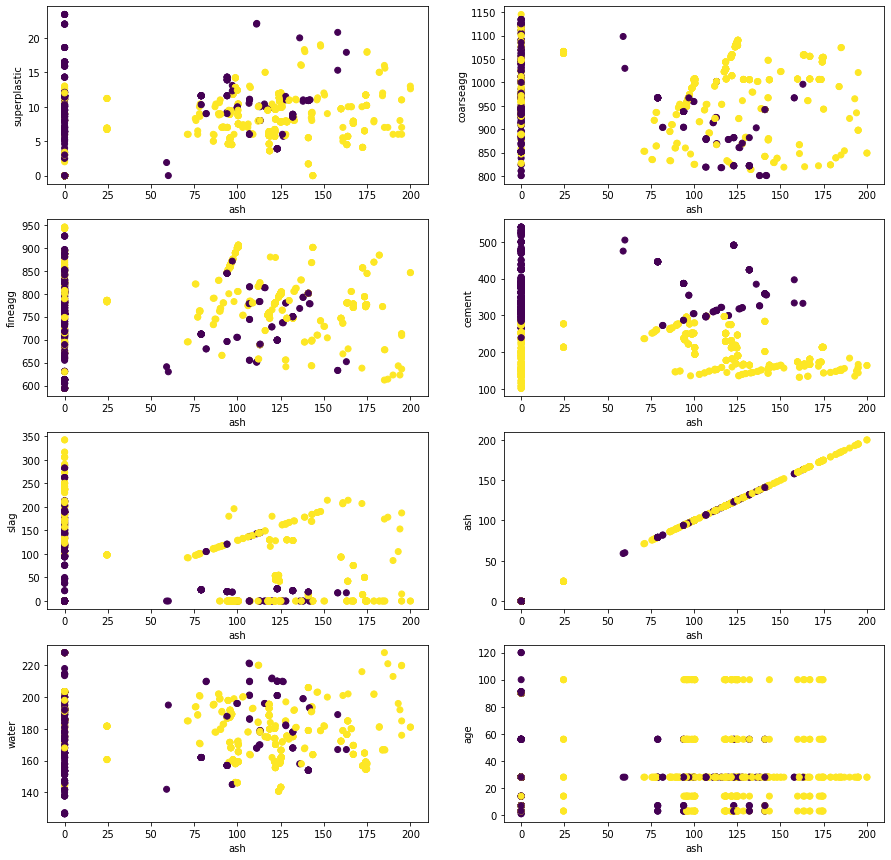

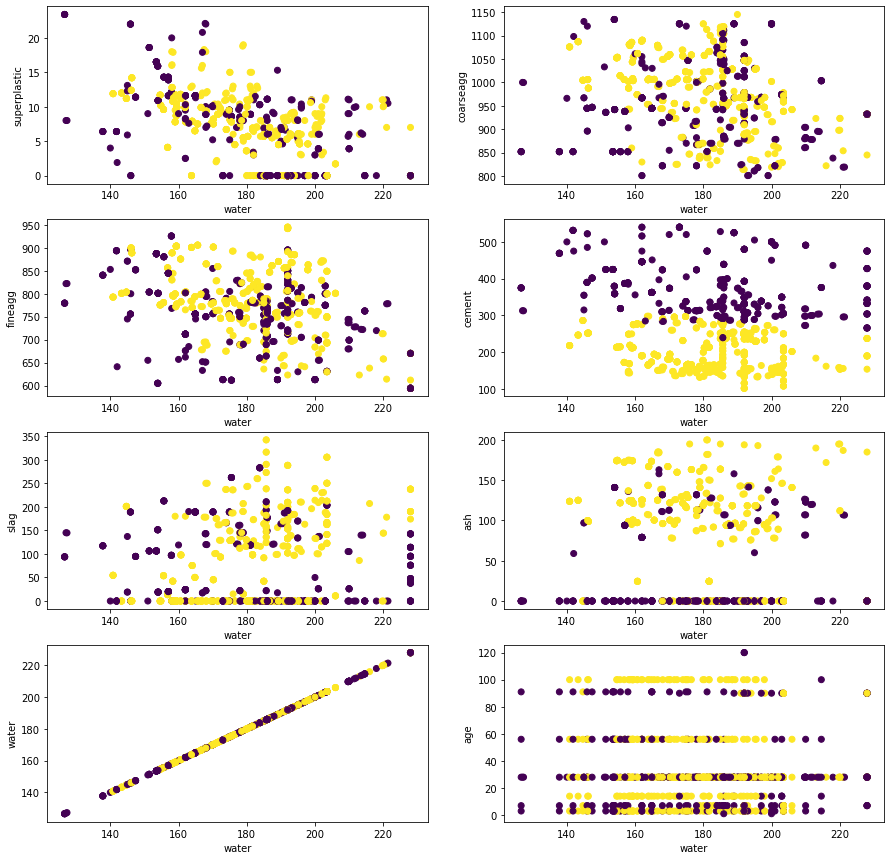

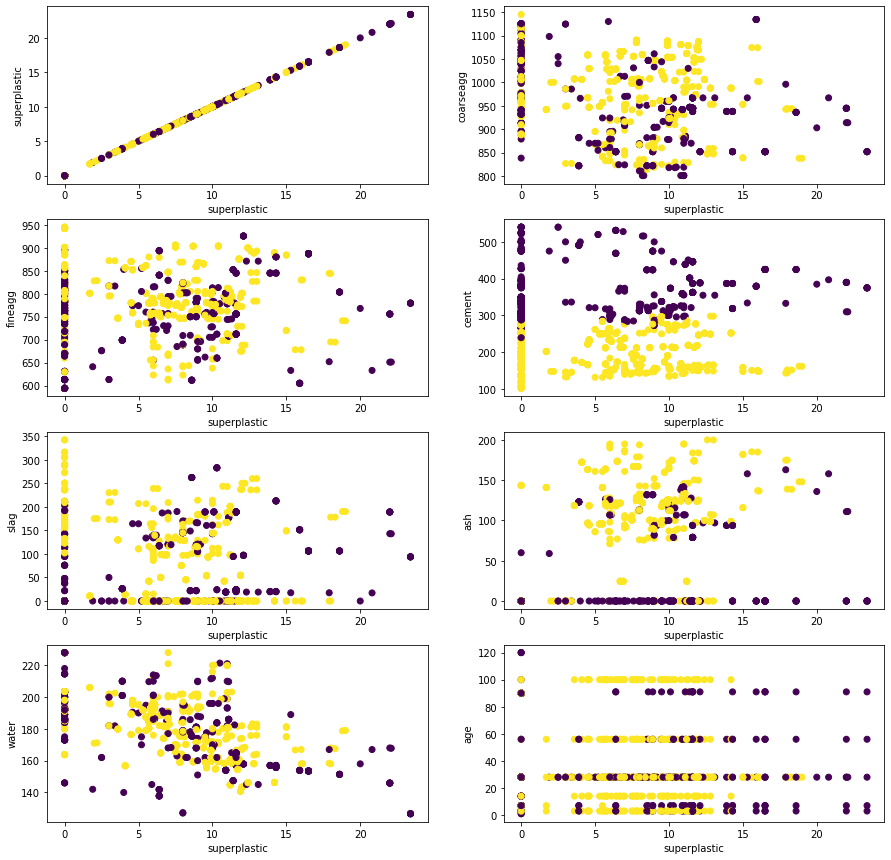

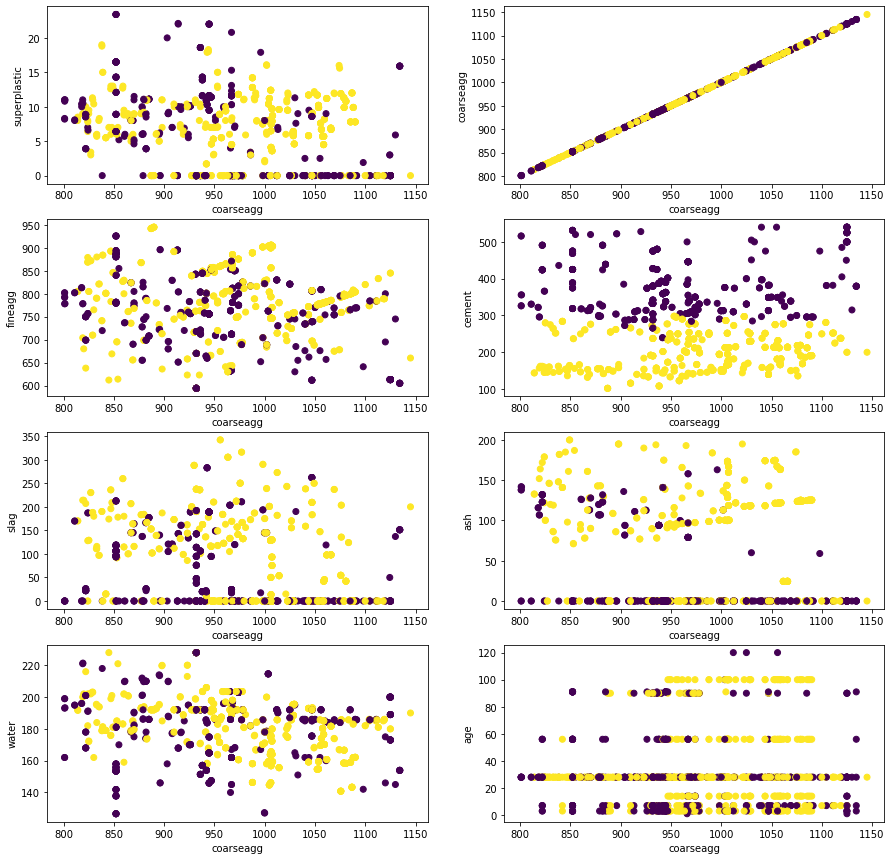

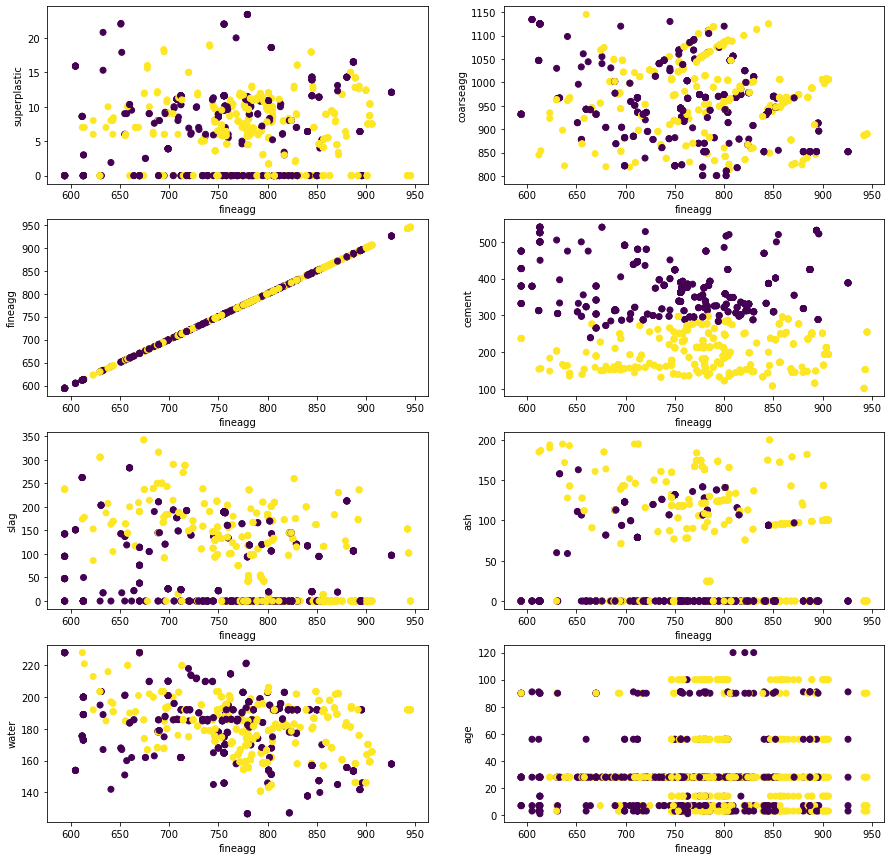

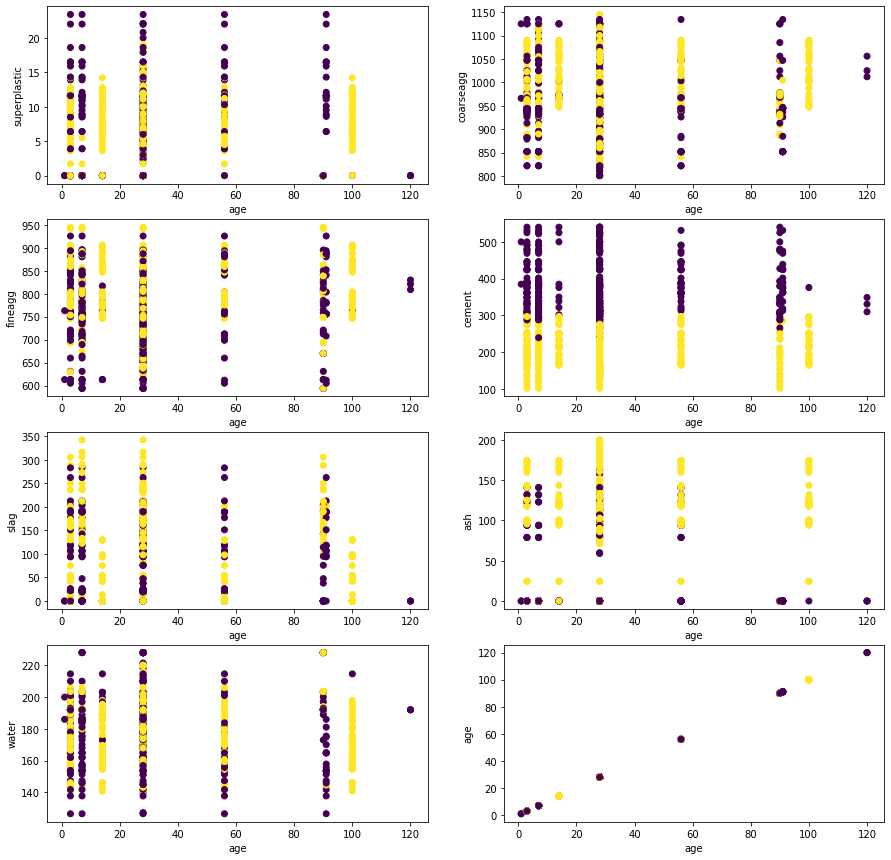

In [42]:
for col in x.columns:
    clustering(x, col, clusters)

## Analysis

cement is forming clusters with every features.


In [43]:
new_df = df.join(pd.DataFrame(clusters, columns=['clusters']), how= 'left')
new_df.head()

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength,clusters
0,141.3,212.0,0.0,203.5,0.0,971.8,748.5,28.0,29.89,1
1,168.9,42.2,124.3,158.3,10.8,1080.8,796.2,14.0,23.51,1
2,250.0,0.0,95.7,187.4,5.5,956.9,861.2,28.0,29.22,1
3,266.0,114.0,0.0,228.0,0.0,932.0,670.0,28.0,45.85,0
4,154.8,183.4,0.0,193.3,9.1,1047.4,696.7,28.0,18.29,1


In [44]:
cluster_df = new_df.groupby('clusters')['cement'].agg(['mean', 'median']) #performing grupby on clsters col and doing agg operations with cement col.

In [45]:
cluster_df.head()

,mean,median
clusters,,
0,376.731317,362.6
1,203.132804,202.0


In [46]:
cluster_df = new_df.merge(cluster_df, on= 'clusters', how= 'left')

In [47]:
cluster_df.head()

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength,clusters,mean,median
0,141.3,212.0,0.0,203.5,0.0,971.8,748.5,28.0,29.89,1,203.132804,202.0
1,168.9,42.2,124.3,158.3,10.8,1080.8,796.2,14.0,23.51,1,203.132804,202.0
2,250.0,0.0,95.7,187.4,5.5,956.9,861.2,28.0,29.22,1,203.132804,202.0
3,266.0,114.0,0.0,228.0,0.0,932.0,670.0,28.0,45.85,0,376.731317,362.6
4,154.8,183.4,0.0,193.3,9.1,1047.4,696.7,28.0,18.29,1,203.132804,202.0


For every 1 the mean and median values is same and for 0 only its changing. So, to consider curse of dimensionality its better to drop clusters column.

In [48]:
multiple_models(cluster_df, 'strength') #checking accuracies for clster df

,model_name,rmse,r2_score
5,RandomForestRegressor,5.875360,0.859472
6,XGBRegressor,6.245079,0.841230
9,GradientBoostingRegressor,6.834513,0.809845
7,DecisionTreeRegressor,7.436015,0.774901
8,AdaBoostRegressor,7.805379,0.751984
1,Lasso regression,9.176730,0.657178
2,Ridge regression,9.200571,0.655395
0,Linear regression,9.200585,0.655394
4,KNeighborsRegressor,10.024409,0.590918
3,SVR,13.717915,0.233930


In [49]:
x = cluster_df.drop(['strength', 'clusters'], axis=1)
y = cluster_df['strength']

In [50]:
K_fold_CV(x, y)

,model_names,score_mean,score_std
9,XGBRegressor,0.899436,0.046856
6,RandomForestRegressor,0.885422,0.035116
8,GradientBoostingRegressor,0.875596,0.044935
4,DecisionTreeRegressor,0.836167,0.055080
7,AdaBoostRegressor,0.740521,0.029900
2,Ridge,0.686641,0.062314
1,Lasso,0.686437,0.062413
0,LinearRegression,0.686391,0.062270
5,KNeighborsRegressor,0.669395,0.088242
3,SVR,0.246843,0.044778


In [51]:
cv_post_hpt(x, y)

,model_names,score_mean,score_std
9,XGBRegressor,0.905124,0.044717
8,GradientBoostingRegressor,0.891111,0.052484
6,RandomForestRegressor,0.882511,0.036167
4,DecisionTreeRegressor,0.788836,0.088153
7,AdaBoostRegressor,0.733310,0.037279
1,Lasso,0.686641,0.062319
2,Ridge,0.686640,0.062314
0,LinearRegression,0.686391,0.062270
5,KNeighborsRegressor,0.669395,0.088242
3,SVR,0.246843,0.044778


## Understanding feature importance using xgboost

In [52]:
xtrain, xtest, ytrain, ytest = train_and_test_split(cluster_df.drop('clusters', axis= 1), tcol='strength')

In [53]:
xgb = XGBRegressor()

In [54]:
xgb.fit(xtrain, ytrain)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

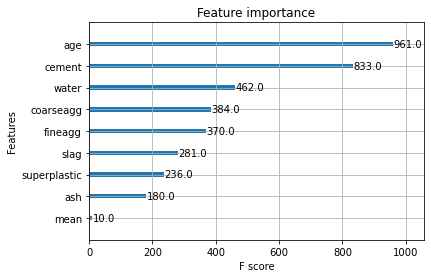

In [55]:
xgboost.plot_importance(xgb)

In [56]:
new_df1 = cluster_df[['age', 'cement', 'water', 'coarseagg', 'fineagg', 'strength']]
new_df1.head()

,age,cement,water,coarseagg,fineagg,strength
0,28.0,141.3,203.5,971.8,748.5,29.89
1,14.0,168.9,158.3,1080.8,796.2,23.51
2,28.0,250.0,187.4,956.9,861.2,29.22
3,28.0,266.0,228.0,932.0,670.0,45.85
4,28.0,154.8,193.3,1047.4,696.7,18.29


In [57]:
cv_post_hpt(x= new_df1.drop('strength', axis=1), y=new_df1['strength'])

,model_names,score_mean,score_std
9,XGBRegressor,0.888168,0.045352
8,GradientBoostingRegressor,0.876493,0.046166
6,RandomForestRegressor,0.852016,0.040203
4,DecisionTreeRegressor,0.804602,0.076943
7,AdaBoostRegressor,0.704127,0.044495
1,Lasso,0.657583,0.060431
2,Ridge,0.657579,0.060465
0,LinearRegression,0.657579,0.060465
5,KNeighborsRegressor,0.645391,0.079298
3,SVR,0.252828,0.044987


## RFE

In [58]:
cluster_df.head()

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength,clusters,mean,median
0,141.3,212.0,0.0,203.5,0.0,971.8,748.5,28.0,29.89,1,203.132804,202.0
1,168.9,42.2,124.3,158.3,10.8,1080.8,796.2,14.0,23.51,1,203.132804,202.0
2,250.0,0.0,95.7,187.4,5.5,956.9,861.2,28.0,29.22,1,203.132804,202.0
3,266.0,114.0,0.0,228.0,0.0,932.0,670.0,28.0,45.85,0,376.731317,362.6
4,154.8,183.4,0.0,193.3,9.1,1047.4,696.7,28.0,18.29,1,203.132804,202.0


In [59]:
rfe = RFE(GradientBoostingRegressor())

In [60]:
rfe.fit(cluster_df.drop(['strength', 'clusters'], axis=1), y=cluster_df['strength'])

RFE(estimator=GradientBoostingRegressor())

In [61]:
rfe.support_

array([ True,  True, False,  True,  True, False, False,  True, False,
       False])

In [62]:
cluster_df.columns

Index(['cement', 'slag', 'ash', 'water', 'superplastic', 'coarseagg',
       'fineagg', 'age', 'strength', 'clusters', 'mean', 'median'],
      dtype='object')

In [63]:
new_df2 = cluster_df[['cement', 'slag', 'water', 'superplastic', 'age', 'strength']] #these are imp features by rfe.

In [64]:
cv_post_hpt(new_df2.drop('strength', axis=1), y=cluster_df['strength'])

,model_names,score_mean,score_std
9,XGBRegressor,0.898842,0.041095
8,GradientBoostingRegressor,0.885006,0.051457
6,RandomForestRegressor,0.884432,0.036144
4,DecisionTreeRegressor,0.823134,0.047002
5,KNeighborsRegressor,0.764651,0.062967
7,AdaBoostRegressor,0.733878,0.036231
1,Lasso,0.671703,0.059072
2,Ridge,0.671701,0.059147
0,LinearRegression,0.671701,0.059148
3,SVR,0.560489,0.042917


## Building learning curve analysis

In [65]:
def generate_learning_curve(estimator, x, y, model_name):
    train_size, train_score, test_score = learning_curve(estimator= estimator, X=x, y=y, cv=10)
    train_score_mean = np.mean(train_score, axis=1)
    test_score_mean = np.mean(test_score, axis=1)
    plt.plot(train_size, train_score_mean, c= 'b')
    plt.plot(train_size, test_score_mean, c= 'r')
    plt.xlabel('Samples')
    plt.ylabel('Accuracies')
    plt.title('Learning Curve for '+ model_name)
    plt.legend(('training_accuracy','testing_accuracy'))

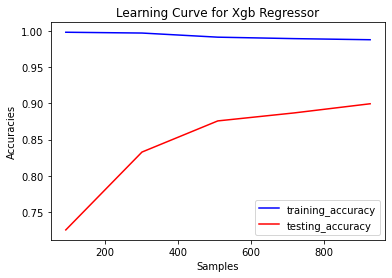

In [66]:
generate_learning_curve(XGBRegressor(), x=new_df2.drop('strength', axis=1), y= new_df2['strength'], model_name= 'Xgb Regressor')

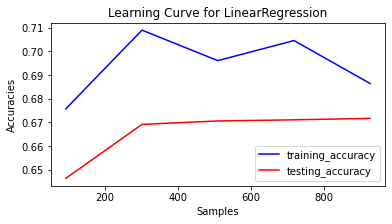

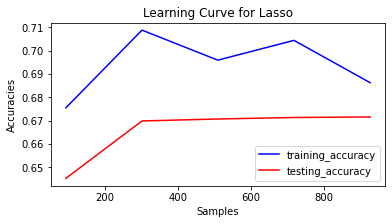

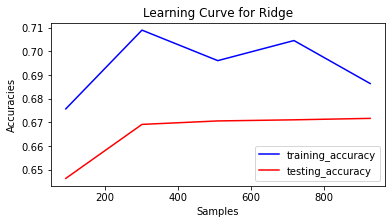

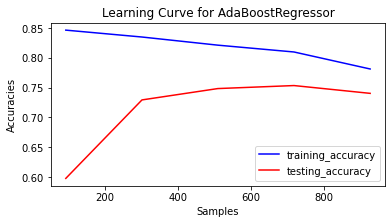

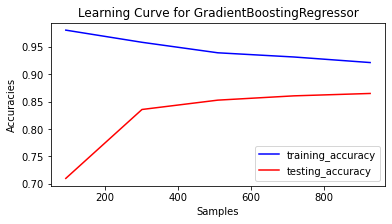

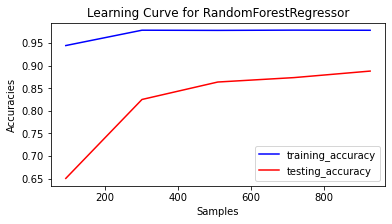

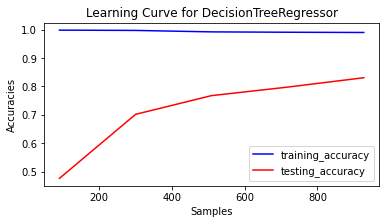

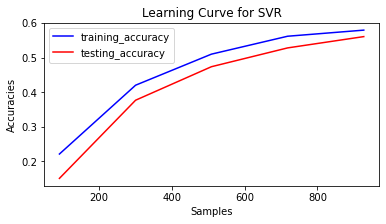

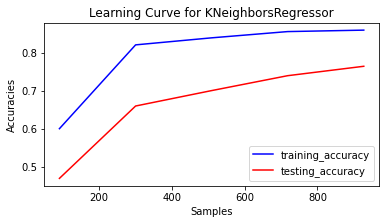

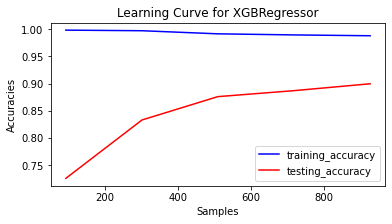

In [67]:
model_names = [LinearRegression(), Lasso(), Ridge(), AdaBoostRegressor(), GradientBoostingRegressor(), 
               RandomForestRegressor(), DecisionTreeRegressor() ,SVR(), KNeighborsRegressor(),
               XGBRegressor()]

for a, model in enumerate(model_names):
    fg = plt.figure(figsize = (6,3))
    ax = fig.add_subplot(5,2,a+1)
    generate_learning_curve(model_name = type(model_names[a]).__name__ , estimator = model, x=new_df2.drop('strength', axis=1), y= new_df2['strength'])

checking training and testing accuracies but diff should not be more than 5%. Then compare where accuracies is high and no of samples where diff not more than 5%. 